# Import Lib

In [1]:
import pandas as pd
from underthesea import word_tokenize
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk

from sklearn.metrics import classification_report, confusion_matrix

# Graph
import seaborn as sns
import matplotlib.pyplot as plt

import re
from sklearn.metrics import classification_report

# Data Loader

In [2]:
def get_Data(path):
    return pd.read_csv(path)

In [3]:
df_train = get_Data('train.csv')
df_test = get_Data('test.csv')

df = pd.concat([df_train, df_test], ignore_index=True)
print(df.shape)
df.head(5)

(30728, 2)


,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0


<Axes: xlabel='label_id', ylabel='count'>

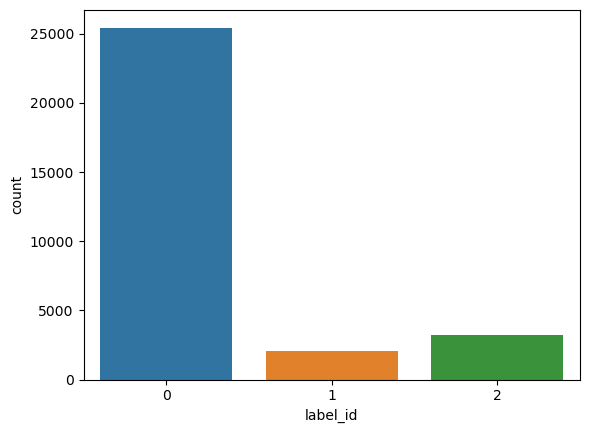

In [4]:
sns.countplot(x='label_id', data=df)

In [5]:
from keras.preprocessing.text import Tokenizer
max = 10000
X = df['free_text'][:max].astype(str)
y = df['label_id'][:max]

for i in range(4):
    print(X[i], end='\t')
    print(y[i])


Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]	0
Đúng là bọn mắt híp lò xo thụt :))) bên việt nam t cái này ra cách đây 10 năm r và bọn t gọi là cái L :)))	2
Đậu Văn Cường giờ giống thằng sida hơn à	0
CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯỚC VN BAN THƯỞNG.	2


### Preprocessing Text

#### Stop Words

In [6]:
stop_words = pd.read_csv('vietnamese-stopwords.txt', header=None)
stop_words = stop_words.iloc[:, 0].values.tolist()

for i in range(4):
    print(stop_words[i])

a lô
a ha
ai
ai ai


In [7]:
def filter_stop_words(sentences, stop_words):
    new_sent = [word for word in sentences.split() if word not in stop_words]
    sentences = ' '.join(new_sent)
    return sentences

X_filtered = [filter_stop_words(sentence, stop_words) for sentence in X]

for i in range(5):
    print(X[i])

print('------')

for i in range(5):
    print(X_filtered[i])

Em được làm fan cứng luôn rồi nè ❤️ reaction quá hay quá cute coi mấy giờ này quá hợp lí =]]]
Đúng là bọn mắt híp lò xo thụt :))) bên việt nam t cái này ra cách đây 10 năm r và bọn t gọi là cái L :)))
Đậu Văn Cường giờ giống thằng sida hơn à
CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯỚC VN BAN THƯỞNG.
Từ lý thuyết đến thực hành là cả 1 câu chuyện dài =))
------
Em fan cứng nè ❤️ reaction cute coi mấy hợp lí =]]]
Đúng bọn mắt híp lò xo thụt :))) việt nam t 10 r bọn t gọi L :)))
Đậu Văn Cường thằng sida
CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯỚC VN BAN THƯỞNG.
Từ lý thuyết thực hành 1 câu =))


#### Tokenize

In [8]:
Xnew = [word_tokenize(sent,format='text').lower() for sent in X_filtered]

for i in range(5):
    print(Xnew[i])

em fan cứng nè ❤ ️ reaction cute coi mấy hợp_lí = ]_] ]
đúng bọn mắt híp lò_xo thụt :))) việt_nam t 10 r bọn t gọi l :)))
đậu_văn_cường thằng sida
côn_đồ cục_súc vô_nhân_tính đề_nghi_vn. nhà_nước vn ban_thưởng .
từ lý_thuyết thực_hành 1 câu =))


In [9]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import text_to_word_sequence

# n-gram
n = 2 
Xnew_ngram = []
for sent in X_filtered:
    words = text_to_word_sequence(sent)
    n_grams = [' '.join(words[i:i+n]) for i in range(len(words)-1)]
    Xnew_ngram.append(n_grams)

In [18]:
# Khởi tạo Tokenizer và sử dụng bigram (n-gram với n=2)
t = Tokenizer()
t.fit_on_texts(Xnew_ngram)

In [19]:
# X = t.texts_to_matrix(Xnew, mode='count')
# X = t.texts_to_matrix(Xnew, mode='freq')
X = t.texts_to_matrix(Xnew_ngram, mode='binary')
# X = t.texts_to_matrix(Xnew, mode='tfidf')
print(X.shape)
print(X[:3])

(10000, 48143)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,
                                                    test_size=0.25)
print(X_train.shape)
print(y_train.shape)

(7500, 48143)
(7500,)


# Model

In [58]:
model = []
accuracy = []

In [59]:
from sklearn.metrics import accuracy_score

def classificationReport(X_test, y_test, model):
    return classification_report(y_test, model.predict(X_test))

### Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

In [61]:
model.append('Logistic Regression')
accuracy.append(accuracy_score(y_test, model_lr.predict(X_test)))

print(classificationReport(X_test, y_test, model_lr))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2047
           1       0.54      0.20      0.29       193
           2       0.71      0.50      0.58       260

    accuracy                           0.87      2500
   macro avg       0.71      0.56      0.60      2500
weighted avg       0.84      0.87      0.85      2500



### kNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [63]:
model.append('kNN')
accuracy.append(accuracy_score(y_test, model_knn.predict(X_test)))

print(classificationReport(X_test, y_test, model_knn))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2047
           1       0.67      0.02      0.04       193
           2       1.00      0.02      0.03       260

    accuracy                           0.82      2500
   macro avg       0.83      0.35      0.32      2500
weighted avg       0.83      0.82      0.74      2500



### Decision Tree

In [64]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [65]:
model.append('Decision Tree')
accuracy.append(accuracy_score(y_test, clf.predict(X_test)))

print(classificationReport(X_test, y_test, clf))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      2047
           1       0.32      0.25      0.28       193
           2       0.50      0.44      0.47       260

    accuracy                           0.83      2500
   macro avg       0.57      0.54      0.55      2500
weighted avg       0.81      0.83      0.82      2500



### SVM

In [66]:
from sklearn.svm import SVC

model_svc = SVC()
model_svc.fit(X_train,y_train)

SVC()

In [67]:
model.append('SVC')
accuracy.append(accuracy_score(y_test, model_svc.predict(X_test)))

print(classificationReport(X_test, y_test, model_svc))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2047
           1       0.71      0.06      0.11       193
           2       0.77      0.17      0.28       260

    accuracy                           0.84      2500
   macro avg       0.77      0.41      0.43      2500
weighted avg       0.82      0.84      0.78      2500



# Compare 

## freq

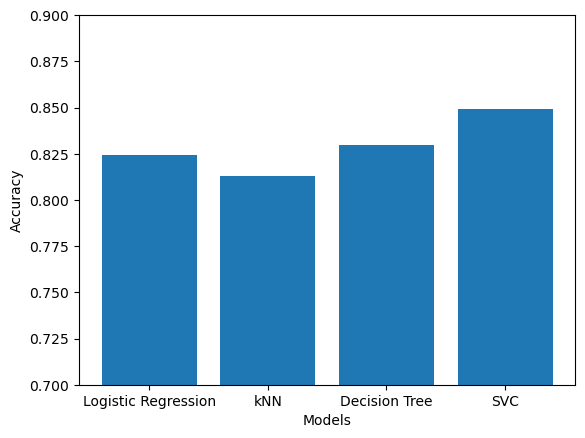

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar(model, accuracy )
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')

ax.set_ylim(0.7, 0.9)

plt.show()

## iftdf

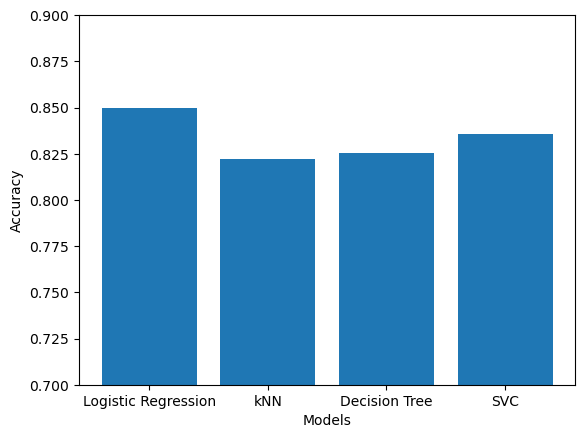

In [42]:
fig, ax = plt.subplots()

ax.bar(model, accuracy )
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')

ax.set_ylim(0.7, 0.9)

plt.show()

## count

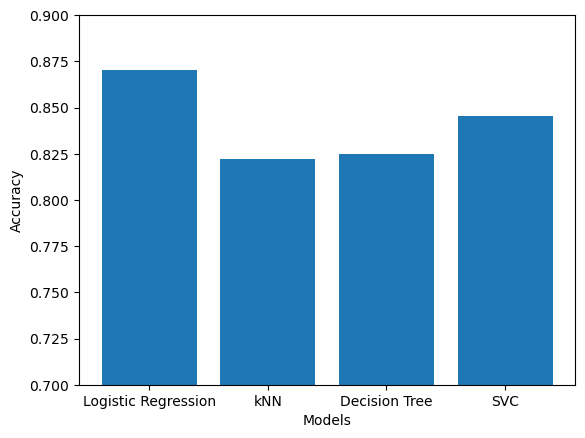

In [55]:
fig, ax = plt.subplots()

ax.bar(model, accuracy )
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')

ax.set_ylim(0.7, 0.9)

plt.show()

## Binary

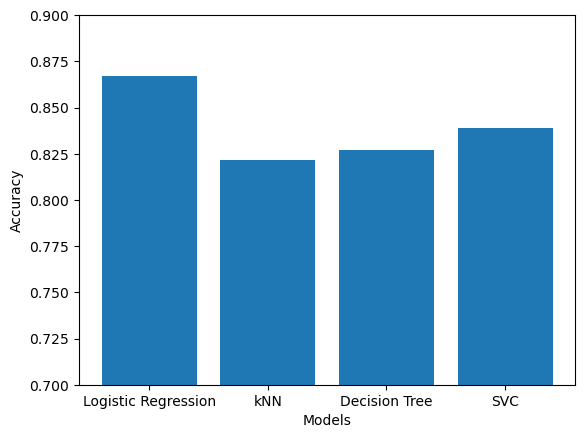

In [68]:
fig, ax = plt.subplots()

ax.bar(model, accuracy )
ax.set_ylabel('Accuracy')
ax.set_xlabel('Models')

ax.set_ylim(0.7, 0.9)

plt.show()

# Sumary

freq
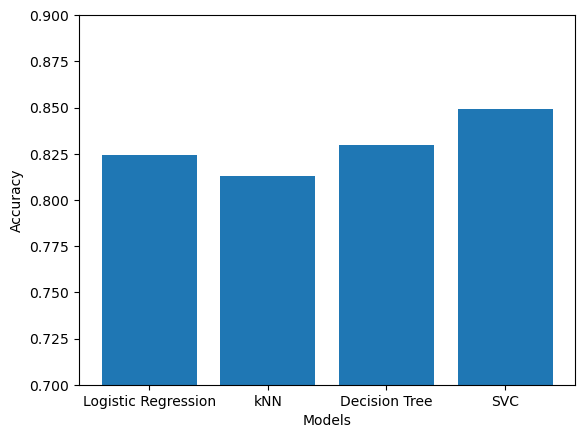
if-tdf
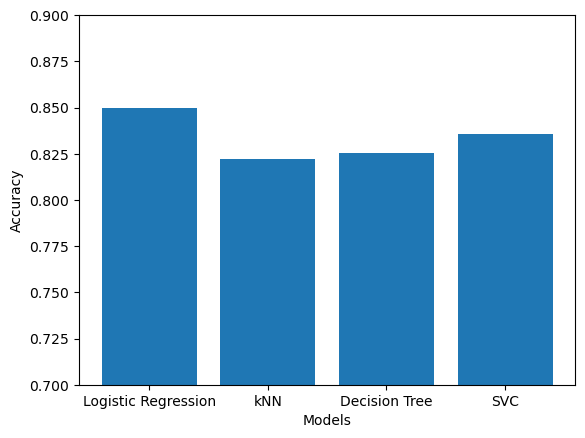
count
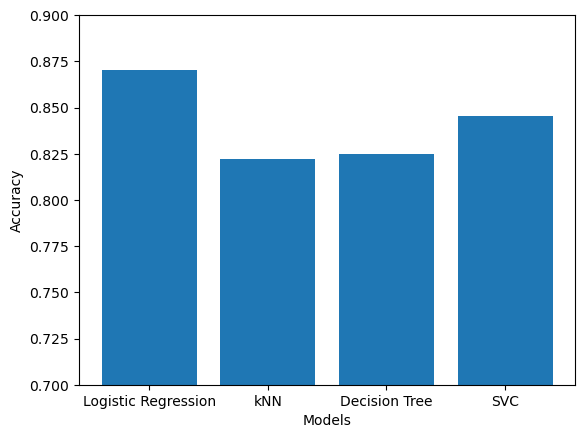
binary
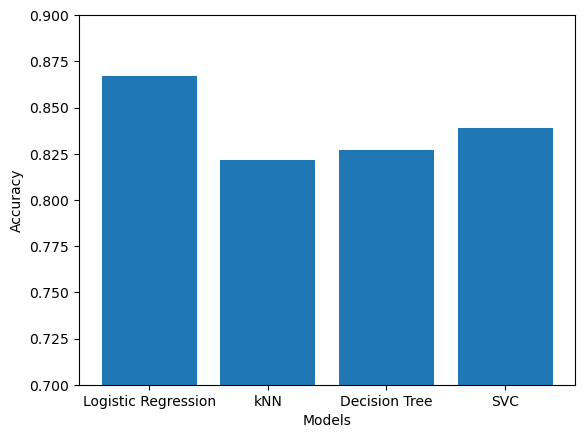